In [24]:
import collections.abc
import os
import pickle
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb
from openretina.dataloaders import dataloaders_from_dictionaries
from openretina.hoefling_2022_configs import model_config, trainer_config
from openretina.misc import CustomPrettyPrinter, redirect_stdout
from openretina.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.plotting import play_stimulus
from openretina.training import standard_early_stop_trainer as trainer

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4)


collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
# from nnfabrik_euler.models.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2022_models import SFB3d_core_SxF3d_readout

# from nnfabrik_euler.training.trainers import standard_early_stop_trainer as trainer

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
stim_dataloaders_dict = pickle.load(
    open("/Data/fd_export/dataloaders_stim_8c18928_responses_99c71a0.pkl", "rb")
)
movies_dict = pickle.load(open("/Data/fd_export/movies_8c18928.pkl", "rb"))

In [66]:
pp.pprint(movies_dict)

{   'left': {   'test': torch.Tensor(shape=[2, 750, 18, 16]),
                'train': {   0: torch.Tensor(shape=[2, 16200, 18, 16]),
                             1: torch.Tensor(shape=[2, 16200, 18, 16]),
                             2: torch.Tensor(shape=[2, 16200, 18, 16]),
                             3: torch.Tensor(shape=[2, 16200, 18, 16]),
                             4: torch.Tensor(shape=[2, 16200, 18, 16]),
                             5: torch.Tensor(shape=[2, 16200, 18, 16]),
                             6: torch.Tensor(shape=[2, 16200, 18, 16]),
                             7: torch.Tensor(shape=[2, 16200, 18, 16]),
                             8: torch.Tensor(shape=[2, 16200, 18, 16]),
                             9: torch.Tensor(shape=[2, 16200, 18, 16]),
                             10: torch.Tensor(shape=[2, 16200, 18, 16]),
                             11: torch.Tensor(shape=[2, 16200, 18, 16]),
                             12: torch.Tensor(shape=[2, 16200, 18, 16]),

In [67]:
16200 / 50

324.0

In [85]:
dataloaders = dataloaders_from_dictionaries(stim_dataloaders_dict, movies_dict, train_chunk_size=99)
model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=1000)

{'1_ventral1_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 86])}, '2_ventral1_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 65])}, '1_ventral2_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 90])}, '2_ventral2_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 95])}, '3_ventral2_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 115])}, '4_ventral2_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 77])}, '5_ventral2_20210929': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 83])}, '1_ventral1_20210930': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 69])}, '1_ventral2_20210930': {'inputs': torch.Size([32, 2, 99, 18, 16]), 'targets': torch.Size([32, 99, 103])}, '2_ventral2_20210930': {'inputs': torch.Size([32, 2,

In [86]:
test_score, val_score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=1000,
    **trainer_config,
    wandb_logger=None,
)

Random seed 1000 has been set.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

> /Projects/open-retina/openretina/hoefling_2022_models.py(563)normal_pdf()
    561         self.mask_var_ = torch.exp(self.mask_log_var * self.gaussian_var_scale).view(-1, 1, 1)
    562         pdf = self.grid - self.mask_mean.view(self.outdims, 1, 1, -1) * self.gaussian_mean_scale
--> 563         pdf = torch.sum(pdf**2, dim=-1) / self.mask_var_
    564         pdf = torch.exp(-0.5 * pdf)
    565         pdf = pdf / torch.sum(pdf, dim=(1, 2), keepdim=True)



In [80]:
%pdb ON

Automatic pdb calling has been turned ON


---
" The core module was modelled as a two-layer convolutional neural network with 16 feature channels in each layer. 

Both layers consisted of space-time separable 3D convolutional kernels followed by a batch normalisation layer and an ELU nonlinearity. In the first layer, sixteen 2 x 11 x 11 x 21 (c=#channels x h=height x w=width x t=#frames) kernels were applied as valid convolution; in the second layer, sixteen 16 x 5 x 5 x 11 kernels were applied with zero padding along the spatial dimensions. 
We parameterised the temporal kernels as Fourier series and added one time stretching pa- rameter per recording to account for inter-experimental vari- ability affecting the speed of retinal processing (78).

In the readout, we modelled each cell’s spatial recep- tive field (RF) as a 2D isotropic Gaussian, parameterised as N (µx,µy ;σ). We then modelled the neural response as an affine function of the core feature maps weighted by the spatial RF, followed by a softplus nonlinearity.

For the linearised version of the model, the architecture was exactly the same except for the fact that there was no ELU nonlinearity after both convolutional layers."

N.B. There are NO fully-connected layers at any point in the architecture. 

The core is FULLY convolutional, allowing for variability in the input time dimension, and the readout also performs operations that are time-agnostic.


In [28]:
test_score

0.4498292360550318

In [84]:
val_field = "1_ventral1_20210929"
val_sample = next(iter(dataloaders["validation"][val_field]))
train_sample = next(iter(dataloaders["train"][val_field]))

StopIteration: 

> /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py(620)_next_index()
    618 
    619     def _next_index(self):
--> 620         return next(self._sampler_iter)  # may raise StopIteration
    621 
    622     def _next_data(self):



In [42]:
validation_samples = val_sample.inputs
train_samples = train_sample.inputs
validation_targets = val_sample.targets

In [43]:
validation_samples.shape

torch.Size([15, 2, 150, 18, 16])

In [44]:
train_samples.shape

torch.Size([32, 2, 50, 18, 16])

In [49]:
with torch.no_grad():
    reconstructions = model(validation_samples.to("cuda:0"), val_field)

core input shape before layer 0: torch.Size([15, 2, 150, 18, 16])
weight_temporal shape: torch.Size([16, 2, 21, 1, 1])
weight_spatial shape: torch.Size([16, 2, 1, 11, 11])
final weight shape: torch.Size([16, 2, 21, 11, 11])
stride: 1, padding: 0
core input shape before layer 1: torch.Size([15, 16, 130, 8, 6])
weight_temporal shape: torch.Size([16, 16, 11, 1, 1])
weight_spatial shape: torch.Size([16, 16, 1, 5, 5])
final weight shape: torch.Size([16, 16, 11, 5, 5])
stride: 1, padding: (0, 2, 2)
core output shape: torch.Size([15, 16, 120, 8, 6])
        Readout input shape: torch.Size([15, 16, 120, 8, 6])
        Readout feature shape: torch.Size([1, 16, 1, 86])
        Readout mask shape: torch.Size([8, 6, 86])
        Readout output shape: torch.Size([15, 120, 86])


In [26]:
random_tensor = torch.rand((1, 2, 200, 16, 16))
test_net = torch.nn.Conv3d(2, 10, kernel_size=(20, 10, 10))

In [27]:
test_net(random_tensor).shape

torch.Size([1, 10, 181, 7, 7])

In [28]:
reconstructions = reconstructions.cpu().numpy().squeeze()
validation_targets = validation_targets.cpu().numpy().squeeze()

In [29]:
validation_targets.shape

(15, 150, 86)

In [30]:
reconstructions.shape

(15, 120, 86)

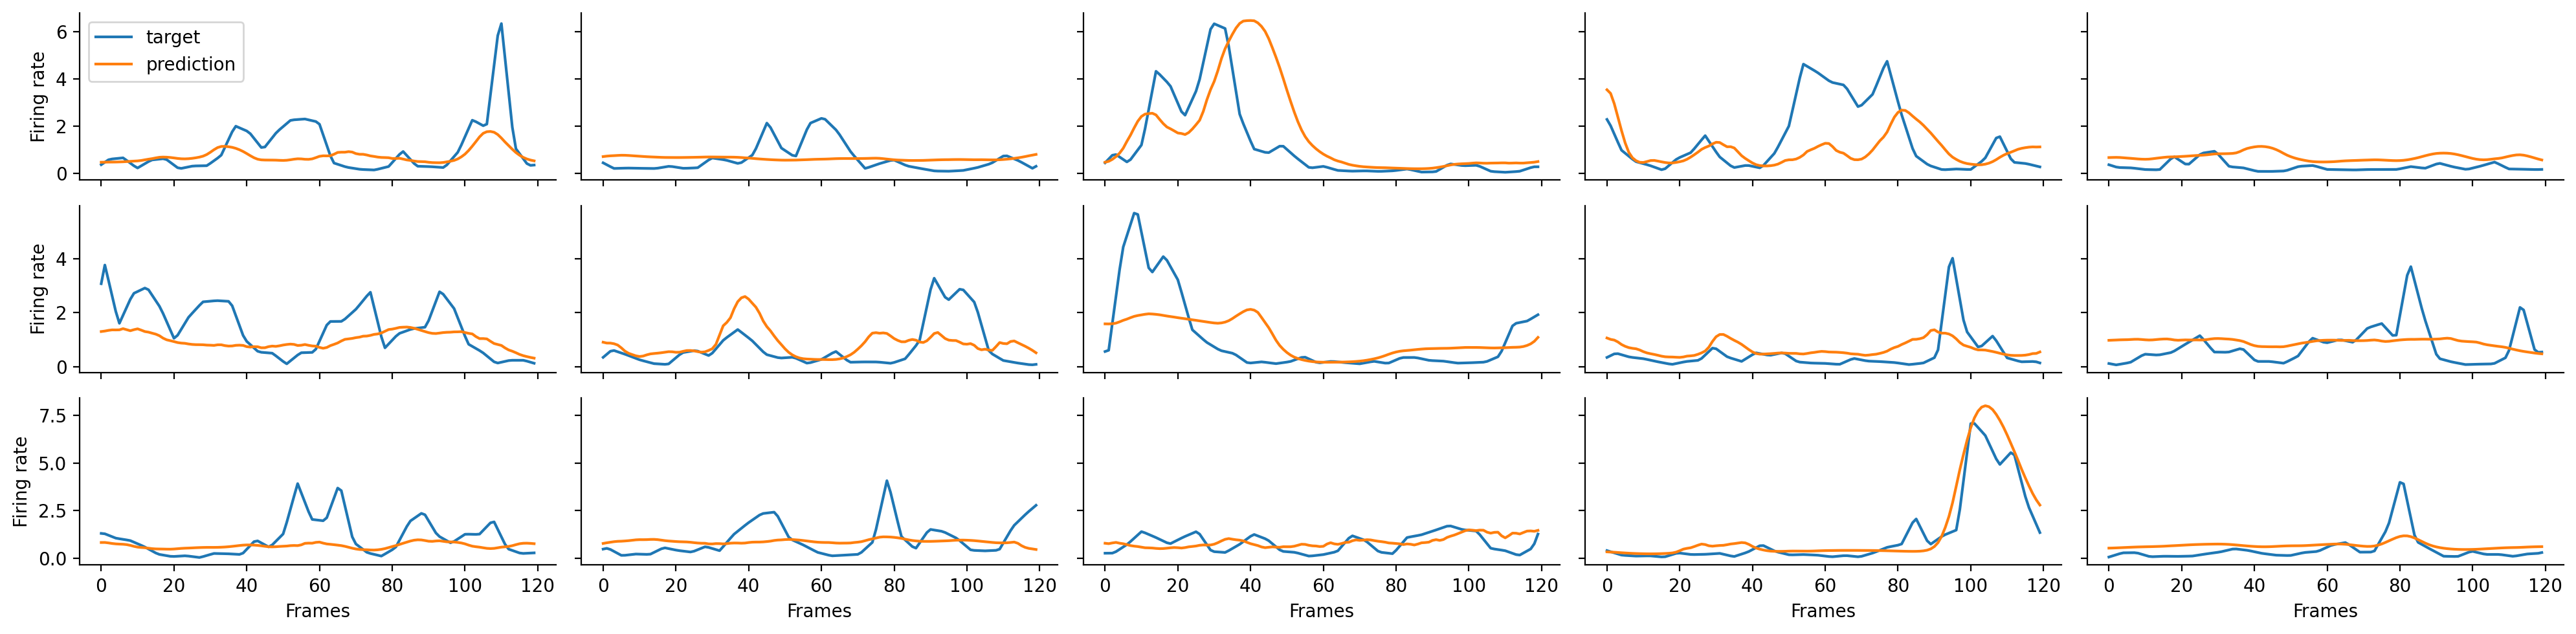

In [31]:
# Your existing code for plotting
neuron = 1
fig, axes = plt.subplots(3, 5, figsize=(20, 5), sharey="row", sharex="col")
for trace_chunk in range(validation_targets.shape[0]):
    ax_idx_1 = trace_chunk // 5
    ax_idx_2 = trace_chunk % 5
    ax = axes[ax_idx_1, ax_idx_2]
    ax.plot(validation_targets[trace_chunk, 30:, neuron], label="target")
    ax.plot(reconstructions[trace_chunk, :, neuron], label="prediction")

    # Set x and y labels for only outer subplots
    if ax_idx_1 == 2:  # Bottom row
        ax.set_xlabel("Frames")
    if ax_idx_2 == 0:  # Leftmost column
        ax.set_ylabel("Firing rate")

    # # Remove inner labels
    # if ax_idx_1 != 2:
    #     ax.set_xticklabels([])
    # if ax_idx_2 != 0:
    #     ax.set_yticklabels([])
    # Only turn on x-axis labels for the bottom row
    if ax_idx_1 == 2:
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

    # Only turn on y-axis labels for the leftmost column
    if ax_idx_2 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

# Place the legend outside of the subplots
axes[0, 0].legend()

sns.despine()

# wandb.log({"reconstruction": fig})
plt.tight_layout()